In [1]:
%reload_ext autoreload
%autoreload 2

from utils.utils import split_csv

from preprocessing.cleaning import get_cleaned_data
from preprocessing.encoding import encode_data

from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis

from modeling.mrmr_feature_selection import plot_cutoffs
from modeling.logistic import run_elastic_net, evaluate_results
from modeling.comparisons import plot_f1_scores

In [2]:
df = encode_data(get_cleaned_data())
combined, blood_only, clinical_only = split_csv(df)
clinical_only_without_mci = clinical_only[clinical_only["P1_PT_TYPE"] != 4]

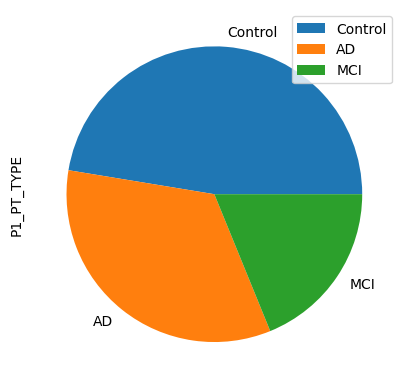

In [3]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

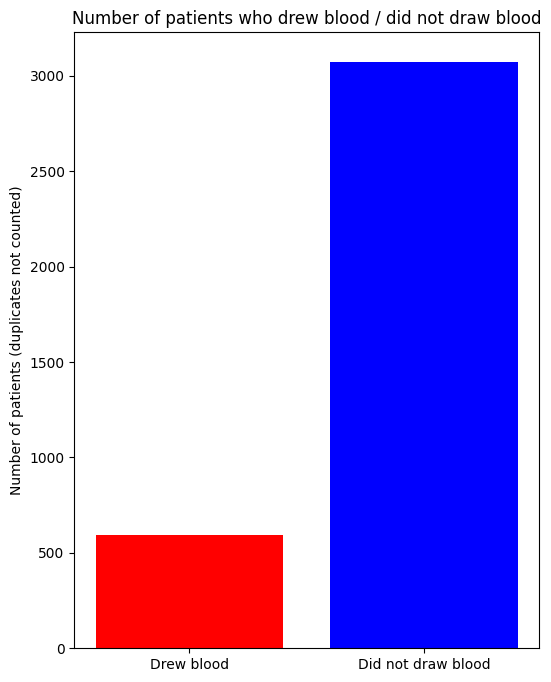

In [4]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

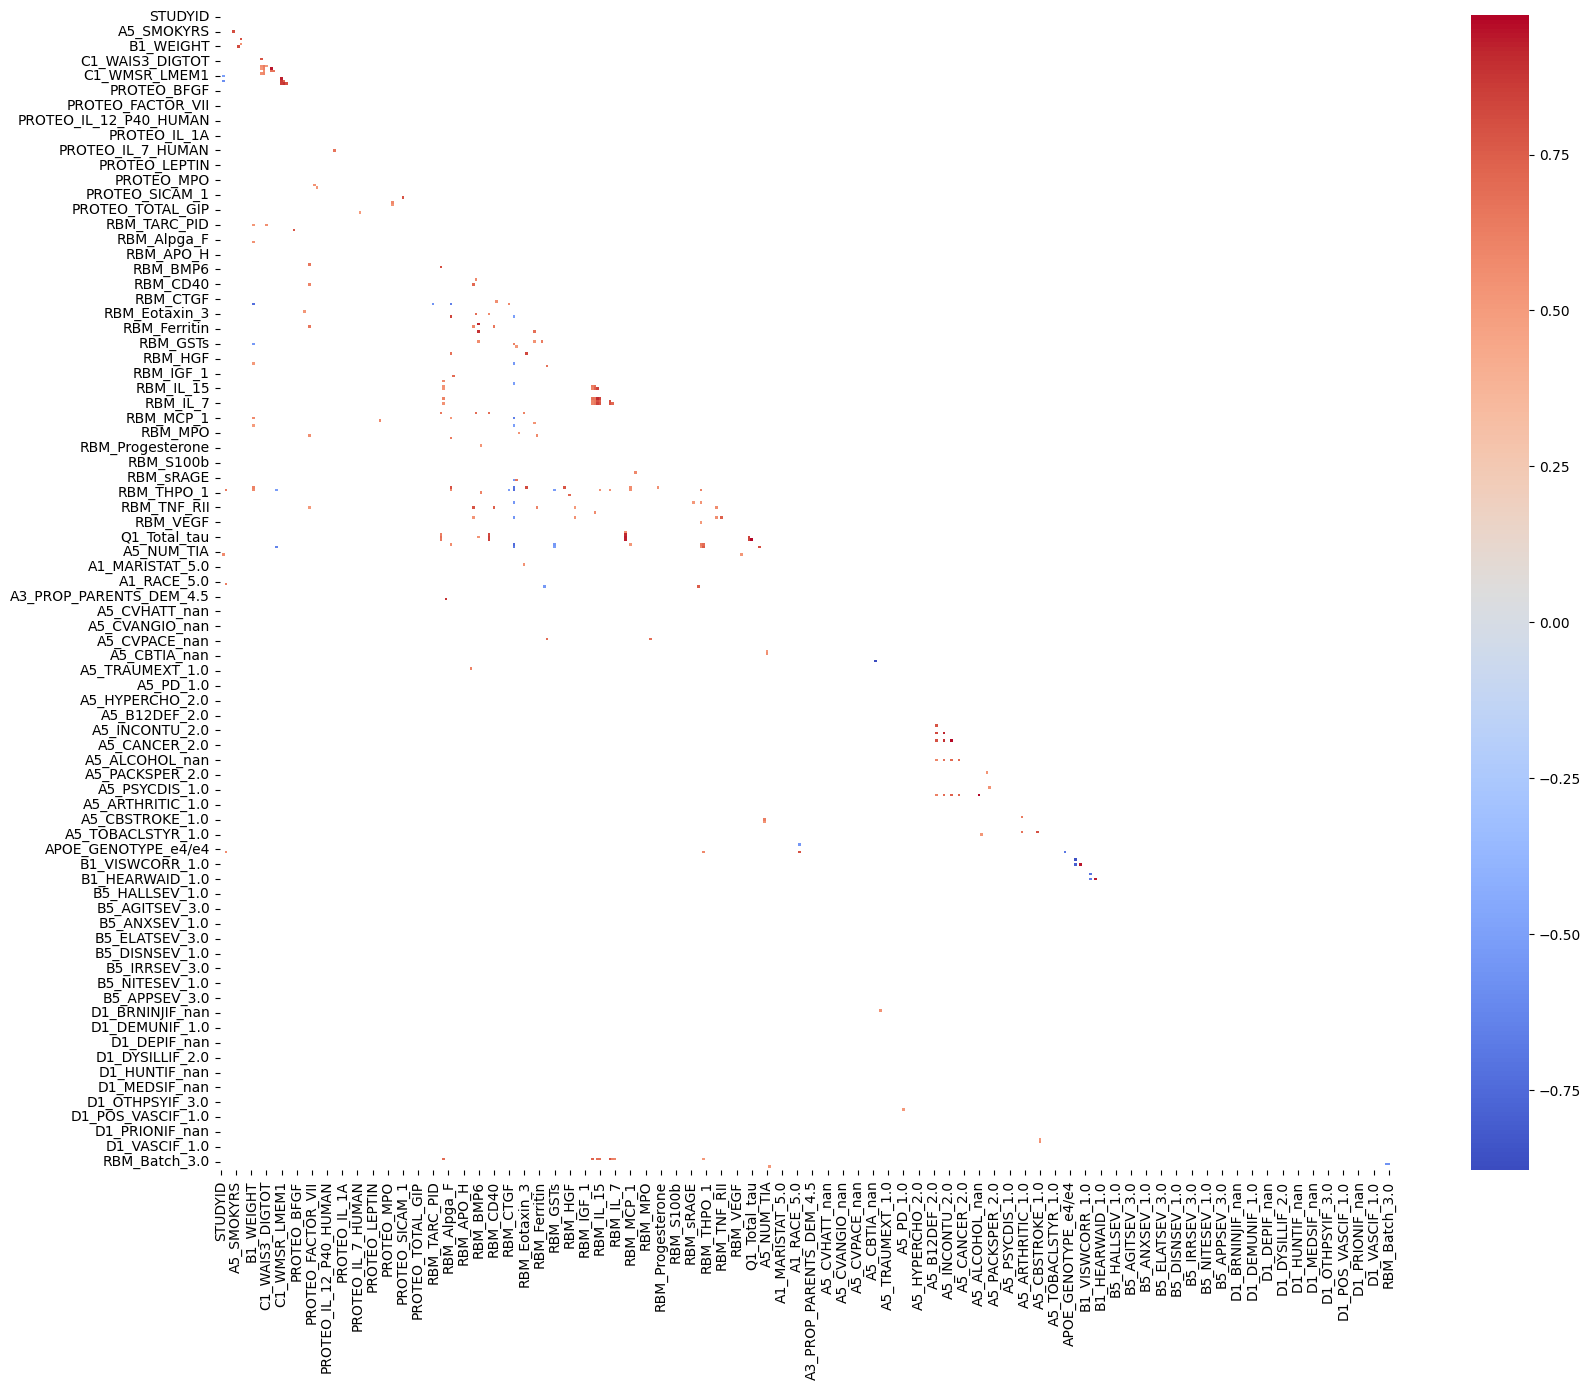

In [5]:
plot_correlations(df)

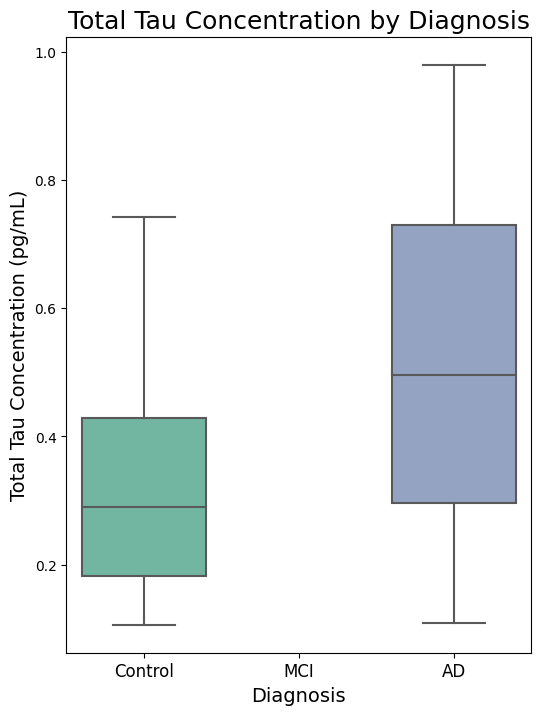

In [6]:
plot_feature_against_diagnosis(
    blood_only,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

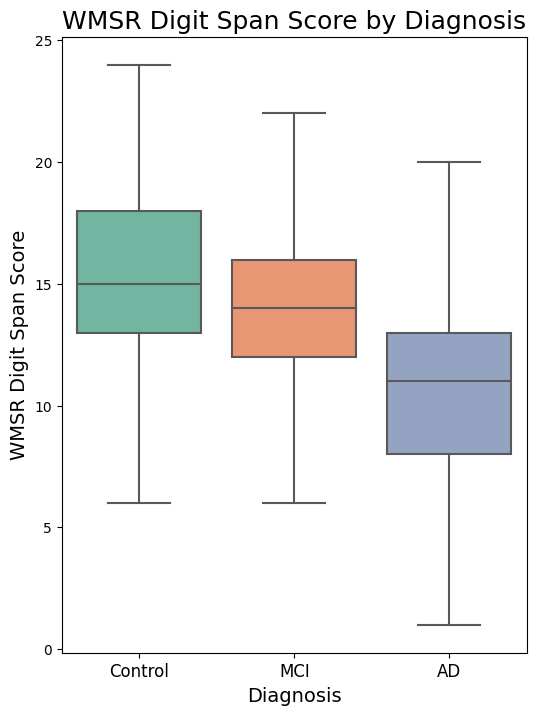

In [8]:
plot_feature_against_diagnosis(
    clinical_only,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

100%|██████████| 348/348 [00:06<00:00, 55.50it/s] 


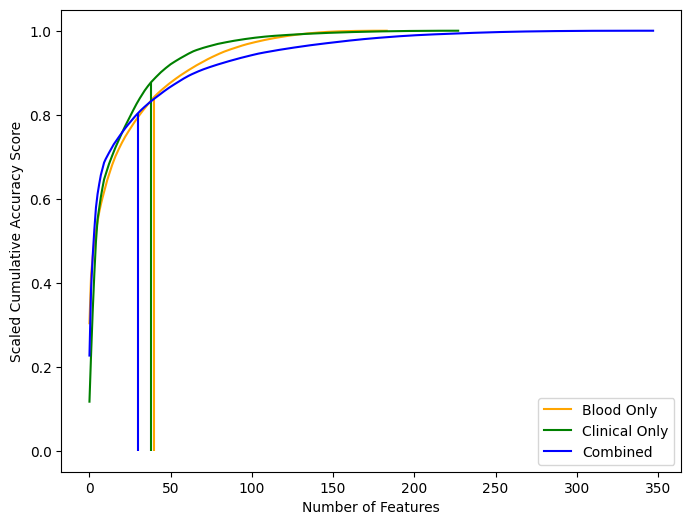

In [4]:
blood_features, clinical_features, combined_features = plot_cutoffs(blood_only, clinical_only, combined)
blood_only_subset = blood_only[blood_features + ["P1_PT_TYPE"]]
clinical_only_subset = clinical_only[clinical_features + ["P1_PT_TYPE"]]
combined_subset = combined[combined_features + ["P1_PT_TYPE"]]
clinical_only_subset_without_mci = clinical_only_subset[clinical_only_subset["P1_PT_TYPE"] != 4]

In [5]:
run_elastic_net(blood_only, num_iters=20, pickle="Blood Only Elastic Net")
blood_logistic_without_mrmr = evaluate_results("Blood Only Elastic Net")

run_elastic_net(clinical_only, num_iters=20, pickle="Clinical Only Elastic Net")
clinical_logistic_without_mrmr = evaluate_results("Clinical Only Elastic Net")

run_elastic_net(combined, num_iters=20, pickle="Combined Elastic Net")
combined_logistic_without_mrmr = evaluate_results("Combined Elastic Net")

Iteration 0
Best C: 0.1
Best l1 ratio: 0.6
Micro-F1 score: 0.8991596638655462
Feature importances: Index(['APOE_GENOTYPE_nan', 'APOE_GENOTYPE_e3/e3', 'RBM_CTGF',
       'APOE_GENOTYPE_e2/e3', 'RBM_THPO', 'RBM_Prolactin', 'PROTEO_FACTOR_VII',
       'RBM_IGF_BP_2', 'PROTEO_PYY', 'Q1_GFAP',
       ...
       'RBM_LH', 'RBM_IL_10', 'PROTEO_TNF_A_HUMAN', 'RBM_Tenascin_C',
       'APOE_GENOTYPE_e3/e4', 'RBM_Haptoglobin', 'PROTEO_FABP3', 'RBM_AXL',
       'PROTEO_VEGF_D', 'RBM_FAS'],
      dtype='object', length=196)
Confusion matrix:
[[52  6]
 [ 6 55]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0.6
Micro-F1 score: 0.8823529411764706
Feature importances: Index(['APOE_GENOTYPE_nan', 'RBM_CTGF', 'APOE_GENOTYPE_e4/e4',
       'APOE_GENOTYPE_e2/e3', 'RBM_THPO', 'PROTEO_FACTOR_VII', 'PROTEO_PYY',
       'RBM_FAS', 'RBM_Factor_VII', 'RBM_HGF',
       ...
       'APOE_GENOTYPE_e3/e3', 'RBM_IGF_BP_2', 'RBM_TNF_beta', 'RBM_MIP_1b',
       'RBM_VWF', 'PROTEO_FLT_1', 'RBM_IL_10', 'RBM_Insulin', 'RBM_Ferri

In [6]:
run_elastic_net(clinical_only_without_mci, num_iters=20, pickle="Clinical Only Elastic Net Without MCI")
clinical_logistic_without_mci_without_mrmr = evaluate_results("Clinical Only Elastic Net Without MCI")

Iteration 0
Best C: 1000.0
Best l1 ratio: 0.8
Micro-F1 score: 0.9685374149659864
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMSR_VRII',
       'C1_WMS3_VRI', 'C1_WMS3_LMEM2', 'C1_SS_TRAILB', 'A1_HISPANIC_1.0',
       'C1_WMSR_LMEM1', 'B5_NPIQINF',
       ...
       'B5_IRRSEV_1.0', 'B5_ANXSEV_1.0', 'A5_CVCHF_2.0', 'A5_INCONTU_2.0',
       'A5_IBD_1.0', 'A5_ALCOHOL_2.0', 'A5_DEP2YRS_nan', 'A5_TOBAC100_1.0',
       'A5_TRAUMBRF_2.0', 'B1_HEARAID_1.0'],
      dtype='object', length=265)
Confusion matrix:
[[ 919   47]
 [  27 1359]]

Iteration 1
Best C: 1000.0
Best l1 ratio: 1
Micro-F1 score: 0.9723639455782312
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMSR_VRII',
       'C1_WMS3_VRI', 'C1_SS_TRAILB', 'C1_WMSR_LMEM1', 'C1_WMS3_LMEM2',
       'A1_HISPANIC_1.0', 'B5_NPIQINF',
       ...
       'A5_ARTHRITIC_1.0', 'A5_B12DEF_1.0', 'B5_DELSEV_2.0', 'A5_THYROID_1.0',
       'A5_HYPERCHO_2.0', 'B1_VISWCORR_1.0', 'A5_DIAB

In [7]:
run_elastic_net(blood_only_subset, num_iters=20, pickle="Blood Only Elastic Net With Feature Selection")
blood_logistic_with_mrmr = evaluate_results("Blood Only Elastic Net With Feature Selection")

run_elastic_net(clinical_only_subset, num_iters=20, pickle="Clinical Only Elastic Net With Feature Selection")
clinical_logistic_with_mrmr = evaluate_results("Clinical Only Elastic Net With Feature Selection")

run_elastic_net(combined_subset, num_iters=20, pickle="Combined Elastic Net With Feature Selection")
combined_logistic_with_mrmr = evaluate_results("Combined Elastic Net With Feature Selection")

Iteration 0
Best C: 0.1
Best l1 ratio: 1
Micro-F1 score: 0.8571428571428571
Feature importances: Index(['APOE_GENOTYPE_nan', 'RBM_Tenascin_C', 'APOE_GENOTYPE_e2/e3',
       'RBM_Factor_VII', 'PROTEO_PYY', 'RBM_IGF_BP_2', 'APOE_GENOTYPE_e4/e4',
       'APOE_GENOTYPE_e3/e3', 'RBM_G_CSF', 'PROTEO_SVCAM_1',
       'PROTEO_IL_12_P40_HUMAN', 'RBM_TNF_beta', 'PROTEO_EOTAXIN_HUMAN',
       'RBM_S100b', 'PROTEO_FLT_1', 'PROTEO_MCP_4_HUMAN', 'RBM_CRP',
       'RBM_Alpha_2', 'RBM_MIP_1b', 'RBM_THPO', 'Q1_Quanterix_1.0',
       'RBM_PAI_1', 'PROTEO_GLUCAGON', 'Q1_Quanterix_tp', 'PROTEO_FABP3',
       'PROTEO_IL_2_HUMAN', 'PROTEO_NT_PROBNP', 'PROTEO_TARC_HUMAN',
       'PROTEO_VEGF_D', 'RBM_IgE', 'RBM_B2M', 'APOE_GENOTYPE_e3/e4', 'RBM_PP',
       'PROTEO_TOTAL_GIP', 'RBM_VDBP', 'RBM_CK_MB', 'PROTEO_PIGF', 'RBM_VWF',
       'RBM_ASP', 'Q1_GFAP'],
      dtype='object')
Confusion matrix:
[[48 13]
 [ 4 54]]

Iteration 1
Best C: 1.0
Best l1 ratio: 0.4
Micro-F1 score: 0.8823529411764706
Feature importanc

In [8]:
run_elastic_net(clinical_only_subset_without_mci, num_iters=20, pickle="Clinical Only Elastic Net Without MCI With Feature Selection")
clinical_logistic_without_mci_with_mrmr = evaluate_results("Clinical Only Elastic Net Without MCI With Feature Selection")

Iteration 0
Best C: 100.0
Best l1 ratio: 0
Micro-F1 score: 0.9634353741496599
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_LMEM2', 'F1_PSMSTOTSCR', 'C1_WMS3_VRI',
       'A1_HISPANIC_1.0', 'C1_SS_TRAILB', 'B5_NPIQINF', 'C1_WMSR_LMEM2',
       'B5_APASEV_1.0', 'D1_DEPIF_2.0', 'B5_DISNSEV_2.0', 'B5_APASEV_3.0',
       'B5_NITESEV_2.0', 'B5_AGITSEV_1.0', 'B5_AGITSEV_2.0', 'D1_DYSILLIF_2.0',
       'B5_MOTSEV_1.0', 'B5_IRRSEV_2.0', 'B5_APPSEV_2.0', 'B5_DISNSEV_1.0',
       'AGE', 'C1_CLOCK', 'B5_APPSEV_1.0', 'C1_SS_TRAILA', 'A5_INCONTU_1.0',
       'B5_NITESEV_1.0', 'B1_BMI', 'B5_ANXSEV_2.0', 'B5_APASEV_2.0',
       'D1_DEMUNIF_1.0', 'B5_DEPDSEV_1.0', 'B5_IRRSEV_1.0', 'B5_MOTSEV_2.0',
       'C1_WMS3_LMEM1', 'A5_ARTHRITIC_1.0', 'B5_DELSEV_1.0', 'C1_WAIS3_DIGTOT',
       'B5_ANXSEV_1.0'],
      dtype='object')
Confusion matrix:
[[ 915   54]
 [  32 1351]]

Iteration 1
Best C: 1.0
Best l1 ratio: 0.6
Micro-F1 score: 0.9570578231292517
Feature importances: Index(['F2_IADLTOTSCR', 'F1_P

In [ ]:
# TODO: Use model results instead of hard-coding.
plot_f1_scores(
    [
        [  # Blood only LR
            0.8403361344537815, 0.8487394957983193, 0.7899159663865545, 0.907563025210084, 0.8823529411764706,
            0.7731092436974791, 0.7815126050420168, 0.7983193277310925, 0.7647058823529412, 0.7899159663865545,
            0.8235294117647058, 0.865546218487395, 0.8235294117647058, 0.8319327731092437, 0.7815126050420168,
            0.8823529411764706, 0.8319327731092437, 0.8739495798319328, 0.8319327731092437, 0.8319327731092437
        ],
        [  # Clinical only LR
            0.8285024154589372, 0.8291925465838509, 0.8405797101449275, 0.8319530710835059, 0.8423050379572119,
            0.8429951690821256, 0.834023464458247, 0.8378191856452726, 0.8391994478951, 0.8374741200828157,
            0.8526570048309179, 0.8378191856452726, 0.831608005521049, 0.8391994478951, 0.8381642512077294,
            0.8409247757073844, 0.8478260869565218, 0.8398895790200138, 0.8405797101449275, 0.841959972394755
        ],
        [  # Combined LR
            0.9411764705882353, 0.9411764705882353, 0.957983193277311, 0.9747899159663865, 0.9411764705882353,
            0.9495798319327731, 0.957983193277311, 0.9663865546218487, 0.957983193277311, 0.9747899159663865,
            0.957983193277311, 0.8991596638655462, 0.9831932773109243, 0.957983193277311, 0.9495798319327731,
            0.9411764705882353, 0.9663865546218487, 0.9243697478991597, 0.9495798319327731, 0.9663865546218487
        ],
        [  # Blood only RF
            0.84033613, 0.85714286, 0.82352941, 0.81512605, 0.85714286, 0.87394958, 0.87394958, 0.85714286, 0.78991597,
            0.8487395, 0.79831933, 0.89915966, 0.8487395, 0.8907563, 0.84033613, 0.79831933, 0.84033613, 0.85714286,
            0.87394958, 0.8487395
        ],
        [  # Clinical only RF
            0.88819876, 0.88371291, 0.8847481, 0.88060732, 0.89061422, 0.88750863, 0.86714976, 0.8857833, 0.88336784,
            0.88923395, 0.88405797, 0.88819876, 0.88095238, 0.88647343, 0.87853692, 0.87853692, 0.88647343, 0.89406487,
            0.88095238, 0.88612836
        ],
        [  # Combined RF
            0.96638655, 0.96638655, 0.97478992, 0.95798319, 0.98319328, 0.96638655, 0.96638655, 0.95798319, 0.97478992,
            0.94117647, 0.95798319, 0.94117647, 0.98319328, 0.96638655, 0.94117647, 0.96638655, 0.93277311, 0.93277311,
            0.97478992, 0.95798319
        ]
    ],
    xlabel="Model",
    ylabel="Micro-F1 Score",
    xticklabels=[
        "LR (Blood)",
        "LR (Clinical)",
        "LR (Combined)",
        "RF (Blood)",
        "RF (Clinical)",
        "RF (Combined)",
    ]
)